In [23]:
!nvidia-smi

# Set CUDA visible devices (e.g., only use GPU 0)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

Thu Nov 28 12:17:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:17:00.0 Off |                    0 |
|  0%   41C    P0             69W /  150W |    3009MiB /  23028MiB |     48%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
token_size = 100


dataloader_shuffle = True
batch_size = 20

# Model Hyperparameters
input_dim = 4 * 100
d_model = 512
d_dense = 512
nhead = 4
num_layers = 1
dim_feedforward = 512
dropout = 0

# Optimization paramters
learning_rate = 0.001
num_epochs = 1000

# Number of samples
num_samples = 160

random_seed = 43

In [25]:
# Flags

SAMPLING = False
FIRST_N = True


if SAMPLING==False & FIRST_N==False: batch_size = 16

n,m = 1000, 1160

In [26]:
import os
import pickle
import numpy as np
import torch
import torch.nn.functional as F  # Import F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import random
random.seed(random_seed)

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def extract_timestamp(filename):
    return int(filename.split('_')[-1].split('.')[0])

# Directories for event and pose files
event_dir = "/scratch365/hwu9/MVSECseq_dataset_2dpose_theta_0807/event_normalizedxyt/"
pose_dir = "/scratch365/hwu9/MVSECseq_dataset_2dpose_theta_0807/pose_theta/"

# Sort files by timestamp
event_files = sorted([f for f in os.listdir(event_dir) if f.startswith('events_ts_')], key=extract_timestamp)
pose_files = sorted([f for f in os.listdir(pose_dir) if f.startswith('pose_ts_')], key=extract_timestamp)

# Create a dictionary mapping timestamps to files for easy alignment
event_timestamps = {extract_timestamp(f): f for f in event_files}
pose_timestamps = {extract_timestamp(f): f for f in pose_files}

# Get common timestamps and align the files
common_timestamps = sorted(set(event_timestamps.keys()) & set(pose_timestamps.keys()))
aligned_event_files = [event_timestamps[ts] for ts in common_timestamps]
aligned_pose_files = [pose_timestamps[ts] for ts in common_timestamps]

# Randomly sample 16 pose files and their corresponding event files
sampled_indices = random.sample(range(len(aligned_pose_files)), num_samples)
sampled_event_files = [aligned_event_files[i] for i in sampled_indices]
sampled_pose_files = [aligned_pose_files[i] for i in sampled_indices]

# First n datapoints
first_n_event_files = event_files[n:m]
first_n_pose_files = pose_files[n:m]

In [27]:
class EventPoseDataset(Dataset):
    def __init__(self, event_files, pose_files, event_dir, pose_dir, token_size):
        self.event_files = event_files
        self.pose_files = pose_files
        self.event_dir = event_dir
        self.pose_dir = pose_dir
        self.token_size = token_size

    def __len__(self):
        return len(self.event_files) 

    def __getitem__(self, idx):
        ef = self.event_files[idx]
        pf = self.pose_files[idx]
        
        # Load event and pose data
        events = load_pickle(os.path.join(self.event_dir, ef))
        pose = load_pickle(os.path.join(self.pose_dir, pf))

        # Ensure event data length is divisible by token_size
        num_events = len(events)
        remainder = num_events % self.token_size
        if remainder != 0:
            padding_length = self.token_size - remainder
            padding = np.zeros((padding_length, 4))
            events = np.vstack((events, padding))

        # Reshape events into tokens
        num_tokens = len(events) // self.token_size
        events = events.reshape(num_tokens, self.token_size * 4)

        # Convert to PyTorch tensors
        events_tensor = torch.tensor(events, dtype=torch.float32)
        pose_tensor = torch.tensor(pose, dtype=torch.float32)
        return events_tensor, pose_tensor

def collate_fn(batch):
    events, poses = zip(*batch)
    events_padded = pad_sequence(events, batch_first=True, padding_value=0)
    poses_tensor = torch.stack(poses)
    mask = (events_padded != 0).float()[:, :, 0] # Use the first column (x) for masking
    return events_padded, poses_tensor, mask


if SAMPLING:
    event_files_to_dataloader = sampled_event_files
    pose_files_to_dataloader = sampled_pose_files
elif FIRST_N:
    event_files_to_dataloader = first_n_event_files
    pose_files_to_dataloader = first_n_pose_files
else:
    event_files_to_dataloader = event_files
    pose_files_to_dataloader = pose_files

# Create dataset and dataloader
dataset = EventPoseDataset(event_files_to_dataloader, pose_files_to_dataloader, event_dir, pose_dir, token_size=token_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)

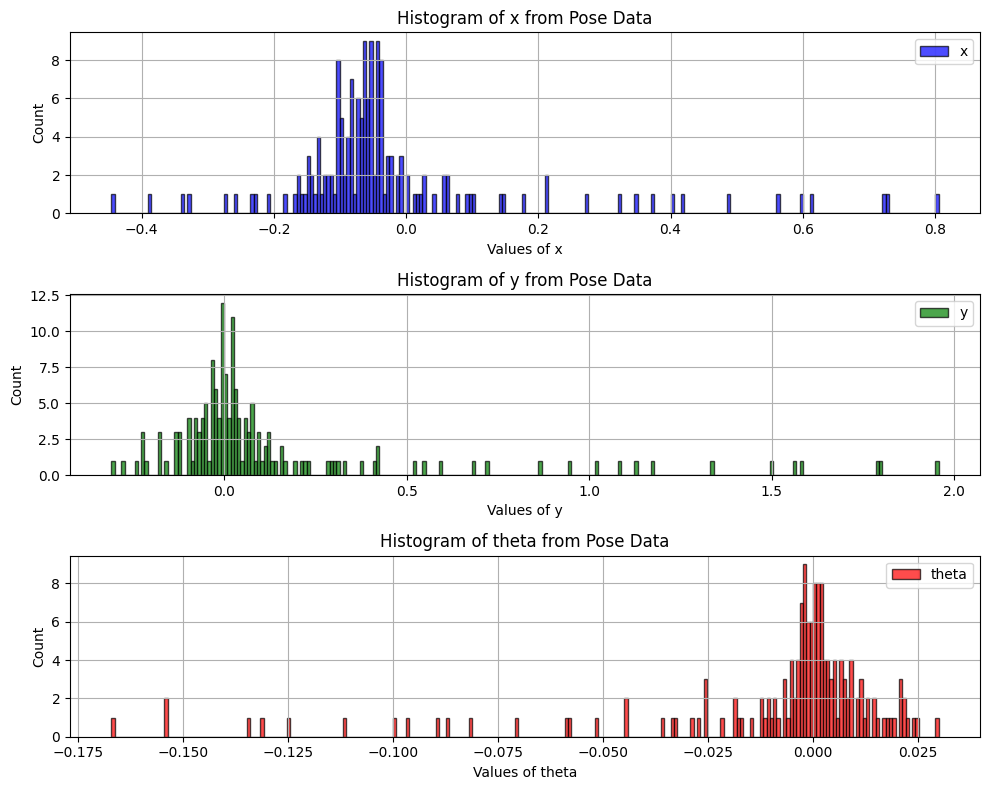

In [28]:
# Plot label distribution

# Initialize lists to hold data for x, y, theta
x_data, y_data, theta_data = [], [], []

# Load data from files
for pose_file in pose_files_to_dataloader:
    file_path = os.path.join(pose_dir, pose_file)
    pose_data = load_pickle(file_path)
    x_data.append(pose_data[0])
    y_data.append(pose_data[1])
    theta_data.append(pose_data[2])

# Convert lists to NumPy arrays for easier manipulation
x_data = np.array(x_data)
y_data = np.array(y_data)
theta_data = np.array(theta_data)

import matplotlib.pyplot as plt

# Define data and labels
data_list = [x_data, y_data, theta_data]
labels = ['x', 'y', 'theta']
colors = ['blue', 'green', 'red']  # Different colors for each histogram

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each histogram
for i, (data, label, color) in enumerate(zip(data_list, labels, colors)):
    axes[i].hist(data, bins=250, alpha=0.7, label=label, edgecolor='black', color=color)
    axes[i].set_xlabel(f'Values of {label}')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Histogram of {label} from Pose Data')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].ticklabel_format(style='plain', axis='x')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

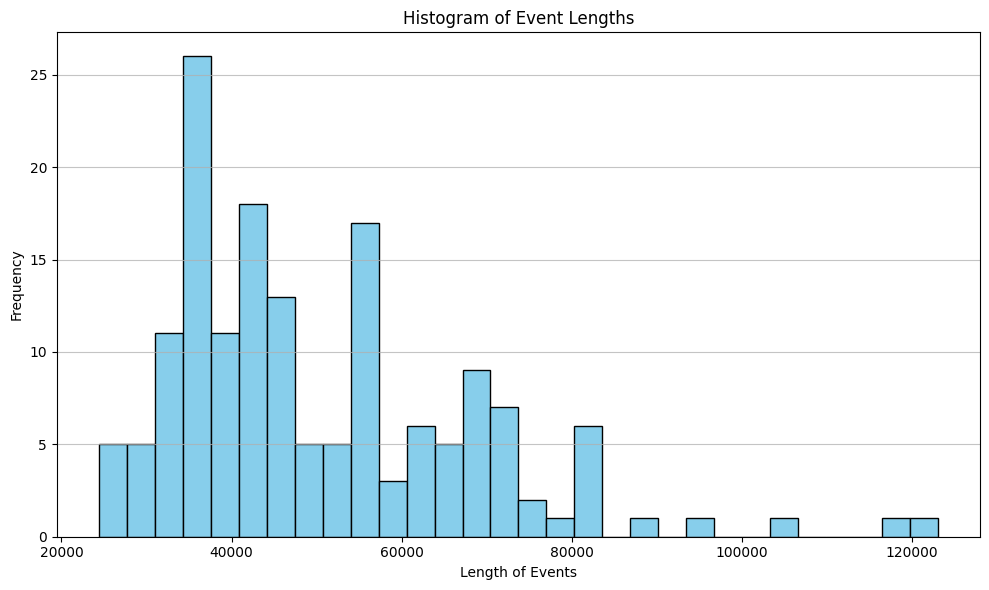

In [38]:
# Plot events lengths

events_len = []

for event_file in event_files_to_dataloader:
    file_path = os.path.join(event_dir, event_file)
    event_data = load_pickle(file_path)
    events_len.append(len(event_data))
    
events_len = np.array(events_len)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(events_len, bins=30, color='skyblue', edgecolor='black')  # You can adjust the number of bins

plt.title('Histogram of Event Lengths')
plt.xlabel('Length of Events')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import pickle
import numpy as np

# Model initialization
class SimplePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class SimpleTransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, d_dense, nhead, num_layers, dim_feedforward, dropout):
        super(SimpleTransformerRegressor, self).__init__()
        self.fc_in = nn.Linear(input_dim, d_model)
        self.pos_encoder = SimplePositionalEncoding(d_model)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        self.fc_out = nn.Linear(d_model, d_dense)
        self.regressor = nn.Linear(d_dense, 3)

    def forward(self, src, src_key_padding_mask=None):
        src = self.fc_in(src)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        output = output.mean(dim=0)
        output = F.relu(self.fc_out(output))
        return self.regressor(output)

model = SimpleTransformerRegressor(input_dim, d_model, d_dense, nhead, num_layers, dim_feedforward, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/afs/crc.nd.edu/user/h/hwu9/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


SimpleTransformerRegressor(
  (fc_in): Linear(in_features=400, out_features=512, bias=True)
  (pos_encoder): SimplePositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=512, out_features=512, bias=True)
  (regressor): Linear(in_features=512, out_features=3, bias=True)
)

In [30]:
# optimize model


# Define loss function
def weighted_mse_loss(input, target, weight):
       return torch.mean(weight * (input - target) ** 2)

weights = torch.tensor([1e5, 1e5, 1e8]).to(device)  # Example weights

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
best_train_loss = float('inf')
best_model_path = "best_model_simple_transformer.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    count_step = 0

    for events, poses, mask in dataloader:
        events, poses, mask = events.to(device), poses.to(device), mask.to(device)
        src_key_padding_mask = mask == 0
        optimizer.zero_grad()
        outputs = model(events, src_key_padding_mask=src_key_padding_mask)
        loss = weighted_mse_loss(outputs, poses, weights)
        #loss = criterion(outputs, poses)

        # # print step loss
        # if count_step % 5 == 0: 
        #     print(f"current loss at step {count_step} epoch {epoch + 1}: ", loss)
        # count_step += 1
        
        loss.backward()
        optimizer.step()
        
    running_loss += loss.item()

    avg_train_loss = running_loss / len(dataloader)

    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.10f}")

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with training loss: {best_train_loss:.10f}")




Epoch [1/1000], Training Loss: 23876.8375000000
Model saved with training loss: 23876.8375000000
Epoch [2/1000], Training Loss: 19814.9421875000
Model saved with training loss: 19814.9421875000
Epoch [3/1000], Training Loss: 37290.4000000000
Epoch [4/1000], Training Loss: 3877.7046875000
Model saved with training loss: 3877.7046875000
Epoch [5/1000], Training Loss: 33788.1156250000
Epoch [6/1000], Training Loss: 3510.0742187500
Model saved with training loss: 3510.0742187500
Epoch [7/1000], Training Loss: 9444.7875000000
Epoch [8/1000], Training Loss: 5570.5312500000
Epoch [9/1000], Training Loss: 2037.1480468750
Model saved with training loss: 2037.1480468750
Epoch [10/1000], Training Loss: 7112.6125000000
Epoch [11/1000], Training Loss: 8334.6054687500
Epoch [12/1000], Training Loss: 3886.8492187500
Epoch [13/1000], Training Loss: 10917.5656250000
Epoch [14/1000], Training Loss: 6097.8761718750
Epoch [15/1000], Training Loss: 6207.9148437500
Epoch [16/1000], Training Loss: 4615.14531

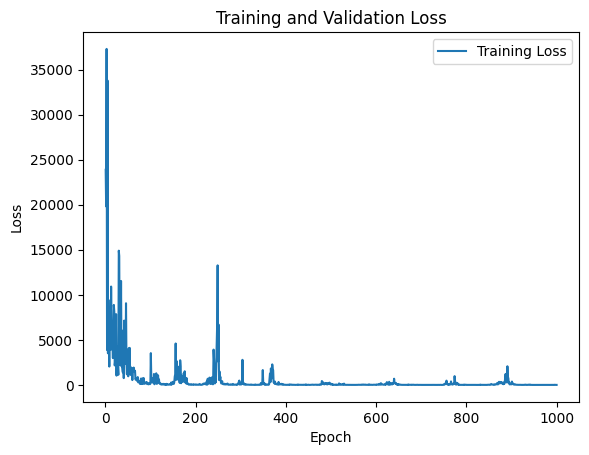

In [31]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [39]:
# Model Evaluation
import torch
import numpy as np
from scipy.linalg import logm
import math
from torch.utils.data import DataLoader
import torch.nn as nn

# Function to normalize a 2D vector
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([0, 0])  # Return a zero vector if norm is zero
    return v / norm

# Evaluation Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#criterion = nn.MSELoss()
batch_size = 1  # Evaluation with one sequence at a time

dataset = EventPoseDataset(event_files_to_dataloader, pose_files_to_dataloader, event_dir, pose_dir, token_size=token_size)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

''''''
# Load the trained model
model = SimpleTransformerRegressor(
    input_dim=4 * token_size,
    d_model=d_model,
    d_dense=d_dense,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

model.load_state_dict(torch.load("best_model_simple_transformer.pth"))
model.to(device)
model.eval()

# Initialize metrics
test_loss = 0.0
x_gt_list, y_gt_list, theta_gt_list = [],[],[]
x_pred_list, y_pred_list, theta_pred_list = [],[],[]

# Initialize Transition matrices and coordinate_list
Tmatrix_gl_gt = np.identity(3, dtype=np.float32)
Tmatrix_gl_pred = np.identity(3, dtype=np.float32)
all_coordinate_gl_gt = np.empty((0,2), dtype=np.float32)
all_coordinate_gl_pred = np.empty((0,2), dtype=np.float32)

# Evaluation loop
with torch.no_grad():
    for events, poses, mask in test_dataloader:
        events, poses, mask = events.to(device), poses.to(device), mask.to(device)

        # Model prediction
        outputs = model(events, src_key_padding_mask=mask == 0)
        
        loss = weighted_mse_loss(outputs, poses, weights)
        #loss = criterion(outputs, poses)
        test_loss += loss.item()

        '''Ground true'''
        pose_gt = poses.cpu().numpy().reshape(-1)
        x_gt, y_gt, theta_gt = pose_gt

        x_gt_list.append(x_gt)
        y_gt_list.append(y_gt)
        theta_gt_list.append(theta_gt)

        # For Ground true trajectory
        Tmatrix_rel_gt =  np.array([[np.cos(theta_gt), - np.sin(theta_gt), x_gt],
                                       [np.sin(theta_gt), np.cos(theta_gt), y_gt],
                                       [0, 0 ,1]])
                                       
        Tmatrix_gl_gt = np.dot(Tmatrix_rel_gt, Tmatrix_gl_gt)

        coordinate_gl_gt = Tmatrix_gl_gt[:2, 2].copy().reshape(1,-1) # Global x, y
        # Append all global coordinates for plotting
        all_coordinate_gl_gt = np.append(all_coordinate_gl_gt, coordinate_gl_gt, axis=0)

        '''Predition'''
        pose_pred = outputs.cpu().numpy().reshape(-1)
        x_pred, y_pred ,theta_pred = pose_pred
        #cos_pred, sin_pred = normalize(pose_pred[2:]) # normalized sin cos

        x_pred_list.append(x_pred)
        y_pred_list.append(y_pred)
        theta_pred_list.append(theta_pred)

        # For Predicted trajectory
        Tmatrix_rel_pred =  np.array([[np.cos(theta_pred), - np.sin(theta_pred), x_pred],
                                       [np.sin(theta_pred), np.cos(theta_pred), y_pred],
                                       [0, 0 ,1]])
        
        Tmatrix_gl_pred = np.dot(Tmatrix_rel_pred, Tmatrix_gl_pred)

        coordinate_gl_pred = Tmatrix_gl_pred[:2, 2].copy().reshape(1,-1) # Global x, y
        # Append all global coordinates for plotting
        all_coordinate_gl_pred = np.append(all_coordinate_gl_pred, coordinate_gl_pred, axis=0)




# Calculate Average Loss
avg_test_loss = test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss:.10f}")



/afs/crc.nd.edu/user/h/hwu9/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Test Loss: 749.2340650707


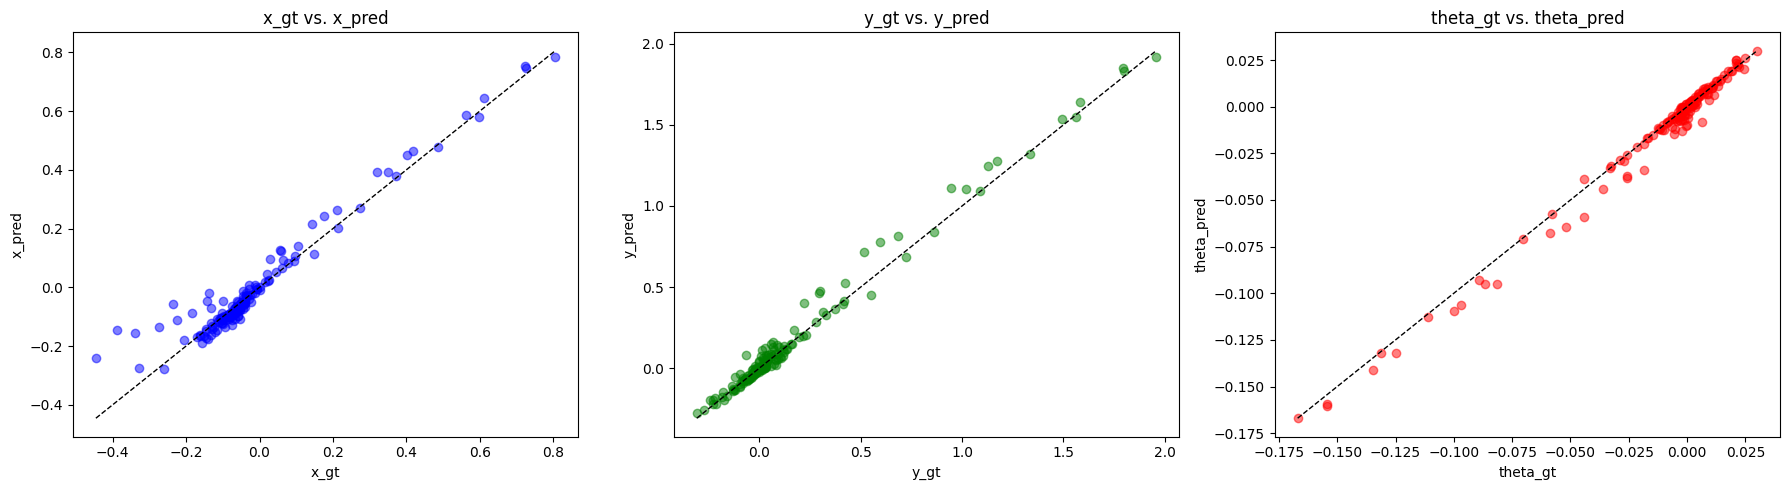

In [34]:
import matplotlib.pyplot as plt

# list to numpy array for ploting
x_gt_array = np.array(x_gt_list)
y_gt_array = np.array(y_gt_list)
theta_gt_array = np.array(theta_gt_list)

x_pred_array = np.array(x_pred_list)
y_pred_array = np.array(y_pred_list)
theta_pred_array = np.array(theta_pred_list)

# Compute min and max values for the dashed lines
x_min = min(min(x_gt_list), min(x_pred_list))
x_max = max(max(x_gt_list), max(x_pred_list))

y_min = min(min(y_gt_list), min(y_pred_list))
y_max = max(max(y_gt_list), max(y_pred_list))

theta_min = min(min(theta_gt_list), min(theta_pred_list))
theta_max = max(max(theta_gt_list), max(theta_pred_list))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: x_gt vs. x_pred
axes[0].scatter(x_gt_list, x_pred_list, color='blue', alpha=0.5)
axes[0].plot([x_min, x_max], [x_min, x_max], 'k--', lw=1)
axes[0].set_xlabel('x_gt')
axes[0].set_ylabel('x_pred')
axes[0].set_title('x_gt vs. x_pred')

# Plot 2: y_gt vs. y_pred
axes[1].scatter(y_gt_list, y_pred_list, color='green', alpha=0.5)
axes[1].plot([y_min, y_max], [y_min, y_max], 'k--', lw=1)
axes[1].set_xlabel('y_gt')
axes[1].set_ylabel('y_pred')
axes[1].set_title('y_gt vs. y_pred')

# Plot 3: theta_gt vs. theta_pred
axes[2].scatter(theta_gt_list, theta_pred_list, color='red', alpha=0.5)
axes[2].plot([theta_min, theta_max], [theta_min, theta_max], 'k--', lw=1)
axes[2].set_xlabel('theta_gt')
axes[2].set_ylabel('theta_pred')
axes[2].set_title('theta_gt vs. theta_pred')

# Adjust layout
plt.tight_layout()
plt.show()


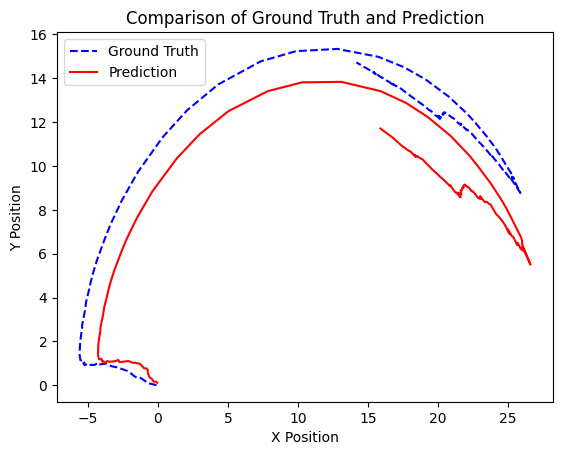

In [43]:
import matplotlib.pyplot as plt

# Create a single figure
fig = plt.figure()

# Plot ground truth
plt.plot(all_coordinate_gl_gt[:, 0], all_coordinate_gl_gt[:, 1], label='Ground Truth', linestyle='--', color='blue')

# Plot prediction
plt.plot(all_coordinate_gl_pred[:, 0], all_coordinate_gl_pred[:, 1], label='Prediction', linestyle='-', color='red')

# Labels, legend, and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Comparison of Ground Truth and Prediction')
plt.legend()

# Show the plot
plt.show()


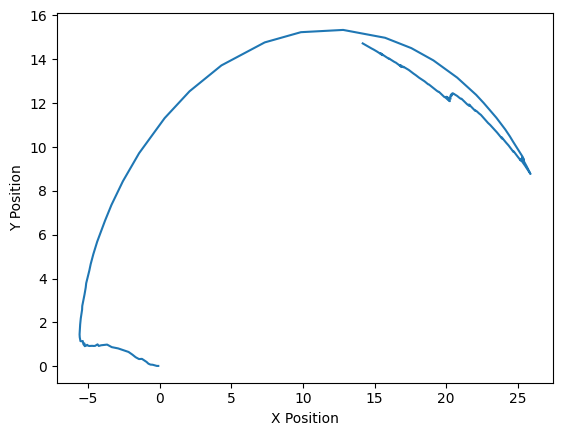

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(all_coordinate_gl_gt[:, 0], all_coordinate_gl_gt[:, 1])

# Labels and legend
plt.xlabel('X Position')
plt.ylabel('Y Position')
#plt.legend()
plt.show()

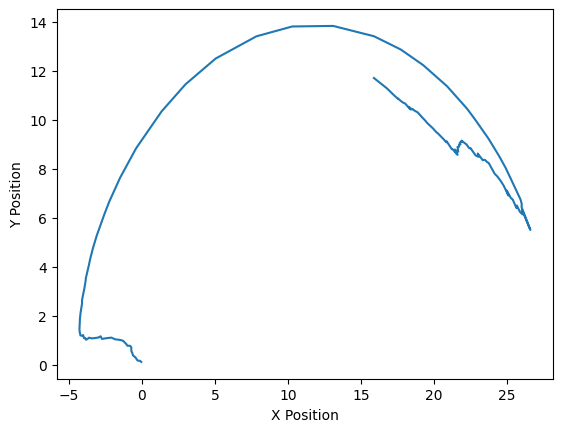

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(all_coordinate_gl_pred[:, 0], all_coordinate_gl_pred[:, 1])

# Labels and legend
plt.xlabel('X Position')
plt.ylabel('Y Position')
#plt.legend()
plt.show()

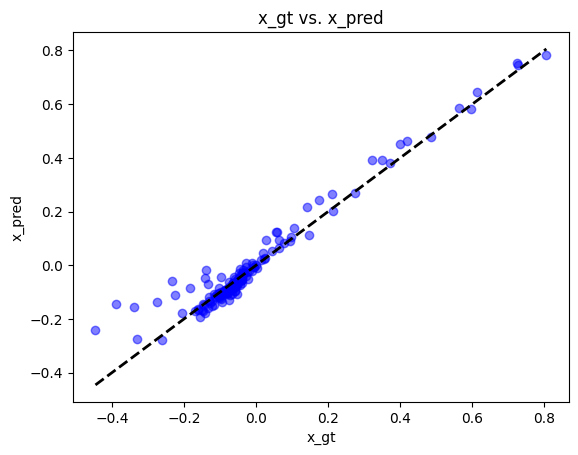

In [35]:
# Plot Ground-Ture vs. Prediction
plt.figure()
plt.scatter(x_gt_list, x_pred_list, color='blue', alpha=0.5)
plt.plot([x_gt_array.min(), x_gt_array.max()], [x_gt_array.min(), x_gt_array.max()], 'k--', lw=2)
plt.xlabel('x_gt')
plt.ylabel('x_pred')
plt.title('x_gt vs. x_pred')
plt.show()

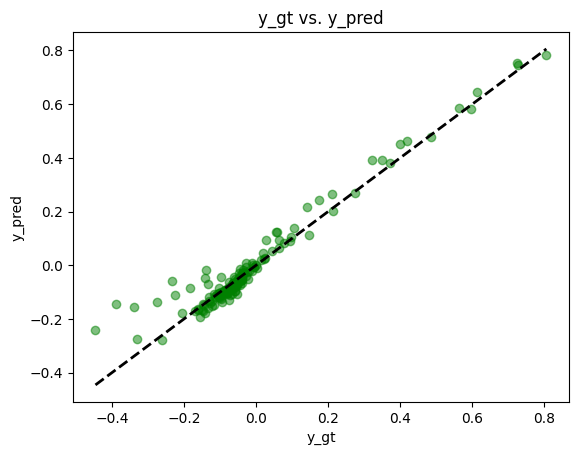

In [36]:
# Plot Ground-Ture vs. Prediction
# Ensure the dashed line spans the entire range of the scatter plot
x_min = min(min(x_gt_list), min(x_pred_list))
x_max = max(max(x_gt_list), max(x_pred_list))

# Plot Ground-Truth vs. Prediction
plt.figure()
plt.scatter(x_gt_list, x_pred_list, color='green', alpha=0.5)
plt.plot([x_min, x_max], [x_min, x_max], 'k--', lw=2)  # Match range to scatter data
plt.xlabel('y_gt')
plt.ylabel('y_pred')
plt.title('y_gt vs. y_pred')
plt.show()


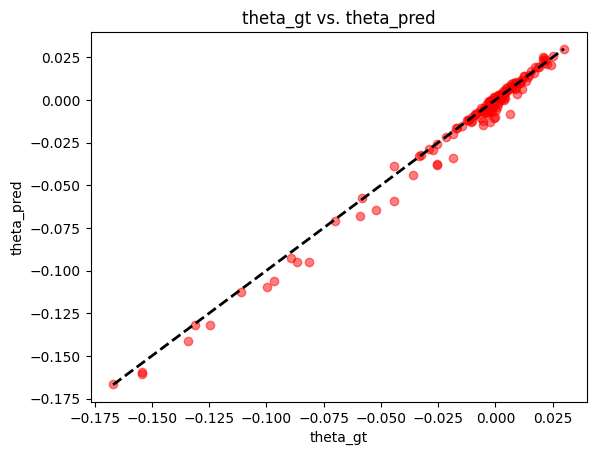

In [37]:
# Plot Ground-Ture vs. Prediction
# Ensure the dashed line spans the entire range of the scatter plot
theta_min = min(min(theta_gt_list), min(theta_pred_list))
theta_max = max(max(theta_gt_list), max(theta_pred_list))

# Plot Ground-Truth vs. Prediction
plt.figure()
plt.scatter(theta_gt_list, theta_pred_list, color='red', alpha=0.5)
plt.plot([theta_min, theta_max], [theta_min, theta_max], 'k--', lw=2)  # Match range to scatter data
plt.xlabel('theta_gt')
plt.ylabel('theta_pred')
plt.title('theta_gt vs. theta_pred')
plt.show()